In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../") # Add parent directory to path
from mfbox import gokunet_df_ratio
from scipy.interpolate import interp1d

In [2]:
# Check if GPU is available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using GPU:", torch.cuda.get_device_name(0))
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [3]:
lna_obj = np.linspace(np.log(1), np.log(1/(1+3)), 30)
zs_obj = 1/np.exp(lna_obj) - 1
zs_old = [0, 0.2, 0.5, 1, 2, 3]
# insert the old zs_obj into the new zs_obj
zs_obj = np.sort(np.append(zs_obj, zs_old))
# remove duplicates
zs_obj = np.unique(zs_obj)

In [4]:
# load input data
x_test = np.loadtxt("../data_local/W_H/train_input.txt")
lgk_test = np.loadtxt("../data_local/W_H/kf.txt")
k_test = 10**lgk_test

n_k = len(lgk_test)
n_z = len(zs_obj)

# normalize input data
# bounds = np.loadtxt("../data_local/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/input_limits.txt")
bounds_path = "../data_local/wide/matter_power_564_Box250_Part750_21_Box1000_Part3000_z0/input_limits.txt"
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test = np.loadtxt("../data_local/W_H/train_output.txt")
# reshape y_test to match the number of k values and z values
# y_test = y_test[:, i_z*n_k:(i_z+1)*n_k]
y_test = y_test.reshape(-1, n_z, n_k)

y_test = 10**y_test

ind_h = [24, 25, 26, 54, 55, 56, 72, 73, 74, 207, 208, 209, 240, 241, 242, 300, 301, 302, 522, 523, 524]

lgk_l1 = np.loadtxt("../data_local/W_L1A/kf.txt")
k_l1 = 10**lgk_l1
n_k_l1 = len(lgk_l1)
y_l1 = np.loadtxt("../data_local/W_L1A/train_output.txt")

y_l1 = 10**y_l1[ind_h]
y_l1 = y_l1.reshape(-1, n_z, n_k_l1)

lgk_l2 = np.loadtxt("../data_local/W_L2/kf.txt")
k_l2 = 10**lgk_l2
n_k_l2 = len(lgk_l2)
y_l2 = np.loadtxt("../data_local/W_L2/train_output.txt")
y_l2 = 10**y_l2[ind_h]
y_l2 = y_l2.reshape(-1, n_z, n_k_l2)



In [5]:
y_test.shape

(21, 34, 143)

In [6]:
x_test.shape

(21, 10)

In [7]:
def power_ratio(k, y_pred, k_test, y_test):

    # find the indices of k_common in k_test
    k_indices = np.where((k_test >= k.min()) & (k_test < k.max()))[0]
    k_common = k_test[k_indices]
    y_test_common = y_test[k_indices]

    # interpolate the values of y_pred at the k_common points in log space
    f = interp1d(np.log10(k), np.log10(y_pred), axis=0, kind='linear')
    y_pred_interp = f(np.log10(k_common))
    # convert back to linear space
    y_pred_interp = 10**y_pred_interp

    # calculate the ratio
    ratio = y_pred_interp / y_test_common
    print("y_test_common", y_test_common)
    print("y_pred_interp", y_pred_interp)

    return k_common, ratio


In [8]:


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    ind_com = np.where((log10_x1 >= common_log10_x_min) & (log10_x1 <= common_log10_x_max) )

    common_log10_x = log10_x1[ind_com]

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

def rMAE_av_cosmo(k_test, y_test, k_pred, y_pred, exclude=None):
    Ps_pred = y_pred
    Ps_sim = y_test
    k_sim = k_test
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_pred, Ps_pred)
    if exclude is not None:  # exclude some cosmologies
        rAEs = np.delete(rAEs, exclude, axis=0)
    rMAE_av = np.mean(rAEs, axis=0)

    # rAE_av_k = np.mean(rAEs, axis=1)

    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

In [9]:
from gokunemu import MatterPowerEmulator
emu = MatterPowerEmulator(device=device)

In [10]:
k, y_h_pred = emu.predict(x_test, redshifts=zs_obj)

In [11]:
from matplotlib import patches


In [12]:
# load input data
x_test_N = np.loadtxt("../data_local/N_H/train_input.txt")
lgk_test = np.loadtxt("../data_local/N_H/kf.txt")
# k_test = 10**lgk_test

# n_k = len(lgk_test)
# n_z = len(zs_obj)

# normalize input data
# bounds = np.loadtxt("../data_local/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/input_limits.txt")
# bounds_path = "../data_local/input_limits-W.txt"
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test_N = np.loadtxt("../data_local/N_H/train_output.txt")
# reshape y_test to match the number of k values and z values
# y_test = y_test[:, i_z*n_k:(i_z+1)*n_k]
y_test_N = y_test_N.reshape(-1, n_z, n_k)

y_test_N = 10**y_test_N

ind_h_N = [144, 145, 146, 168, 169, 170, 195, 196, 197, 204, 205, 206, 336, 337, 338]


lgk_l1 = np.loadtxt("../data_local/N_L1A/kf.txt")
# k_l1 = 10**lgk_l1
# n_k_l1 = len(lgk_l1)
y_l1_N = np.loadtxt("../data_local/N_L1A/train_output.txt")

y_l1_N = 10**y_l1_N[ind_h_N]
y_l1_N = y_l1_N.reshape(-1, n_z, n_k_l1)

lgk_l2 = np.loadtxt("../data_local/N_L2/kf.txt")
# k_l2 = 10**lgk_l2
# n_k_l2 = len(lgk_l2)
y_l2_N = np.loadtxt("../data_local/N_L2/train_output.txt")
y_l2_N = 10**y_l2_N[ind_h_N]
y_l2_N = y_l2_N.reshape(-1, n_z, n_k_l2)

ind_h_N = np.array(ind_h_N) + 564



In [13]:
k, y_h_pred_N = emu.predict(x_test_N, redshifts=zs_obj)

In [14]:
# test speed
# a bunch of calls to the emulator

%timeit emu.predict(x_test[0], redshifts=zs_obj)

9.18 ms ± 172 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
import time

n_calls = 3000  
start = time.time()
for _ in range(n_calls):
    _ = emu.predict(x_test[0], redshifts=zs_obj)
end = time.time()

print(f"Average time per call: {(end - start) / n_calls:.6f} seconds")


Average time per call: 0.007362 seconds


In [16]:
import time

n_calls = 5000  
start = time.time()
for _ in range(n_calls):
    _ = emu.predict(x_test[0], redshifts=[0.,1.1,2.09, 0.33,.44])
end = time.time()

print(f"Average time per call: {(end - start) / n_calls:.6f} seconds")


Average time per call: 0.003466 seconds


average over k: 0.0035908500680011334
average over k: 0.003055133478502517
average over k: 0.003309633422281692
average over k: 0.002360122276719971
average over k: 0.0034350352882353626
average over k: 0.0017317407838035666
average over k: 0.0032685294413287353
average over k: 0.0015578845756493644
average over k: 0.003113122404107931
average over k: 0.0019483693160570817
average over k: 0.003096555236904076
average over k: 0.0018676493279886491
average over k: 0.0031250943488478743
average over k: 0.0021256778617326413
average over k: 0.003010465151912139
average over k: 0.002131097491886857
average over k: 0.0029986962356390087
average over k: 0.0017993717573642574
average over k: 0.0030380137227800515
average over k: 0.0015147169669268705
average over k: 0.002964867527696348
average over k: 0.0015782990943630964
average over k: 0.0027389716878142628
average over k: 0.0014888426661509183
average over k: 0.002824972904393181
average over k: 0.0016111830196109214
average over k: 0.002

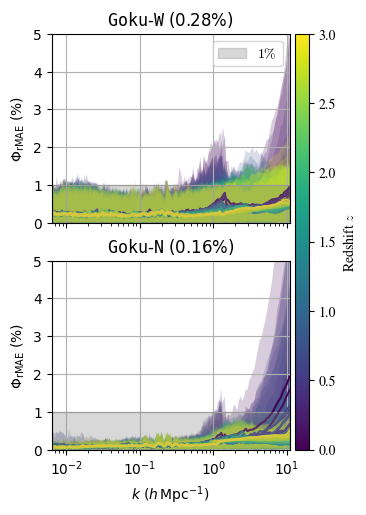

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 1, figsize=(3.7, 5.4))

# similar to Times New Roman
plt.rcParams['font.family'] = 'Nimbus Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'


# zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
# a = 1/(1+zs)
rMAE_cosmos = []
rMAE_cosmos_N = []

cmap = "viridis"
cmap = plt.get_cmap(cmap)
color_list = [x for x in cmap(np.arange(len(zs_obj))/(len(zs_obj)-1))]
# Create a normalization instance and scalar mappable for colorbar
norm = mcolors.Normalize(vmin=min(zs_obj), vmax=max(zs_obj))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed to silence warnings

k_trans_zs = []
n_remove = 0 # number of k bins to remove from the end of k_l1 and the beginning of k_l2, for a smoother transition

for i in range(len(zs_obj)):
    c = color_list[i]
    # find the best k_trans
    # wide


    k_com, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(k_test, y_test[:,i], k, y_h_pred[:,i], exclude=None)

    # plot all cosmologies
    # for j in range(rAEs.shape[0]):
    #     ax.plot(k_com, rAEs[j]/1e-2, color=c, alpha=0.1)

    axes[0].fill_between(k_com, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')

    axes[0].plot(k_com, rMAE/1e-2, color=c)

    print('average over k:', rMAE.mean())
    rMAE_cosmos.append(rMAE.mean())

    # narrow

    k_com, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(k_test, y_test_N[:,i], k, y_h_pred_N[:,i], exclude=None)

    # plot all cosmologies
    # for j in range(rAEs.shape[0]):
    #     ax.plot(k_com, rAEs[j]/1e-2, color=c, alpha=0.1)

    axes[1].fill_between(k_com, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')

    axes[1].plot(k_com, rMAE/1e-2, color=c)

    print('average over k:', rMAE.mean())
    rMAE_cosmos_N.append(rMAE.mean())

rMAE_cosmos = np.array(rMAE_cosmos)
rMAE_cosmos_N = np.array(rMAE_cosmos_N)
k_trans_zs = np.array(k_trans_zs)
# title
axes[0].set_title(r'$\tt{Goku}$' + '-' + r'$\tt{W}$' + f' ({100*rMAE_cosmos.mean():.2f}%)')
axes[1].set_title(r'$\tt{Goku}$' + '-' + r'$\tt{N}$' + f' ({100*rMAE_cosmos_N.mean():.2f}%)')

xlim1 = k_com.min()
xlim2 = k_com.max()
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

for ax in axes:
    ax.set_ylim(0., 5)
    ax.set_xscale('log')
    ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
    ax.grid(True)
    # ensure grid is beneath the lines
    # ax.set_axisbelow(True)
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
    square1 = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='gray', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
    ax.add_patch(square1)
    ax.set_xlim(xlim1, xlim2)

axes[1].set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')

# hide axes[0] x tick labels
axes[0].set_xticklabels([])


axes[0].legend(loc='best')



# add colorbar
# cbar = plt.colorbar(sm, ax=axes[0], pad=0.01)
cbar = plt.colorbar(sm, ax=axes, pad=0.02, aspect=30)

cbar.set_label(r'Redshift $z$')


# plt.show()
# plt.savefig('NEmu_against_WN.pdf', bbox_inches='tight')